<a href="https://colab.research.google.com/github/astrfo/RS-CH/blob/main/RS_CH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://github.com/astrfo/AutonomousOptimalExplorationThroughSatisficing/blob/main/AutonomousOptimalExplorationThroughSatisficing.ipynb




In [93]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy
%matplotlib inline

In [94]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])
        # print(f'prob: {self.prob}')

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [95]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy, param, K):
        if 'RS-CH' == policy:
            self.act_policy = self.RS_CH
            self.aleph = param
            self.RS = np.zeros(K)
        if 'RS-OPT' == policy:
            self.act_policy = self.RS_OPT
            self.aleph = param
            self.RS = np.zeros(K)
        if 'e-greedy' == policy:
            self.act_policy = self.e_greedy
            self.epsilon = param
        if 'random' == policy:
            self.act_policy = self.random_
        if 'ThompsonSampling' == policy:
            self.act_policy = self.ThompsonSampling


    def RS_CH(self, V, n, N):
        self.RS = (n / (N+1)) * (V - self.aleph)        # RS評価値の更新
        G = random.choice(np.where(V == V.max())[0])        # greedyな腕
        mu = np.exp(-n * self.D_KL(V, V[G]))        # μ^CHの計算 (24)
        aleph_list = V[G] * (1 - (V/V[G]) * mu) / (1 - mu)      # R^CHの計算 (25)
        np.nan_to_num(aleph_list, copy=False, nan=-np.inf)
        self.aleph = aleph_list.max()

        # RS_j = copy.deepcopy(self.RS)
        # RS_j[G] = np.nan
        exceed_RSG = np.where(self.RS[G] <= self.RS)[0]

        print(f'G: {G}')
        print(f'V: {V}')
        print(f'RS: {self.RS}')
        print(f'excRS: {exceed_RSG}')
        print(f'mu: {mu}')
        print(f'aleph: {self.aleph}')
        print()

        # if len(exceed_RSG) == 1:     # RS[G]が最も高い
        #     arm = exceed_RSG[0]     # arm = Gと同じ処理
        #     print(f'RS[G]が最大: {arm}')
        # elif len(exceed_RSG) == 2:       # RS[G]以上のRS[j]が1つ存在する場合
        #     if len(np.where(self.RS[G] < self.RS)[0]) == 1:     # RS[G] < RS[j]
        #         arm = np.where(self.RS[G] < self.RS)[0][0]
        #         print(f'RS[G]以上が2つあってRS[G] < RS[j]: {arm}')
        #     else:                                               # RS[G] == RS[j] # これだめかも
        #         arm = np.random.choice(exceed_RSG)
        #         print(f'RS[G]以上が2つあってRS[G] == RS[j]: {arm}')
        # else:
        #     exceed_mu = mu[exceed_RSG]
        #     print(f'mu: {mu}')
        #     print(f'excmu: {exceed_mu}')
        #     if len(np.where(exceed_mu.max() == exceed_mu)[0]) == 1:      # 最も高いμが1つだった場合はその腕を選択
        #         arm = exceed_RSG[np.where(exceed_mu.max() == exceed_mu)[0][0]]
        #         print(f'RS[G]以上が3つ以上でmuの最大が1つ: {arm}')
        #     else:                                                        # 最も高いμが２つ以上だった場合
        #         exceed_aleph = aleph_list[exceed_RSG]
        #         print(f'aleph: {self.aleph}')
        #         print(f'excaleph: {exceed_aleph}')
        #         if len(np.where(exceed_aleph.max() == exceed_aleph)[0]) == 1:     # 最も高いalephが1つだった場合はその腕を選択
        #             arm = exceed_RSG[np.where(exceed_aleph.max() == exceed_aleph)[0][0]]
        #             print(f'RS[G]以上が3つ以上で最大muが複数でalephの最大が1つ: {arm}')
        #         else:                                                           # 最も高いalephが2つ以上だった場合はランダムに選択
        #             arm = np.random.choice(exceed_RSG[np.where(exceed_aleph.max() == exceed_aleph)[0]])
        #             print(f'RS[G]以上が3つ以上で最大muが複数でalephも複数: {arm}')

        



        if len(exceed_RSG) == 1:     # RS[G]が最も高い
            arm = exceed_RSG[0]     # arm = Gと同じ処理
            print(f'RS[G]が最大: {arm}')
        else:
            if len(np.where(self.RS[G] < self.RS)[0]) == 1:     # RS[G] < RS[j]
                arm = np.where(self.RS[G] < self.RS)[0][0]
                print(f'RS[G]以上が2つあってRS[G] < RS[j]: {arm}')
            else:                                               # RS[G] == RS[j] # これだめかも
                exceed_mu = mu[exceed_RSG]
                print(f'excmu: {exceed_mu}')
                if len(np.where(exceed_mu.max() == exceed_mu)[0]) == 1:      # 最も高いμが1つだった場合はその腕を選択
                    arm = exceed_RSG[np.where(exceed_mu.max() == exceed_mu)[0][0]]
                    print(f'RS[G]以上が3つ以上でmuの最大が1つ: {arm}')
                else:                                                        # 最も高いμが２つ以上だった場合
                    exceed_aleph = aleph_list[exceed_RSG]
                    print(f'excaleph: {exceed_aleph}')
                    if len(np.where(exceed_aleph.max() == exceed_aleph)[0]) == 1:     # 最も高いalephが1つだった場合はその腕を選択
                        arm = exceed_RSG[np.where(exceed_aleph.max() == exceed_aleph)[0][0]]
                        print(f'RS[G]以上が3つ以上で最大muが複数でalephの最大が1つ: {arm}')
                    else:                                                           # 最も高いalephが2つ以上だった場合はランダムに選択
                        arm = np.random.choice(exceed_RSG[np.where(exceed_aleph.max() == exceed_aleph)[0]])
                        print(f'RS[G]以上が3つ以上で最大muが複数でalephも複数: {arm}')
            
        print()
        return arm


    def RS_OPT(self, V, n, N):
        self.RS = (n / (N+1)) * (V - self.aleph)
        return np.random.choice(np.where(self.RS == self.RS.max())[0])

    def e_greedy(self, V, _, __):
        if self.epsilon < np.random.rand():
            return np.random.choice(np.where(V == V.max())[0])
        else:
            return np.random.randint(len(V))

    def random_(self, V, _, __):
        return np.random.randint(len(V))

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

    # alpha, beta の初期値
    # def ThompsonSampling(self, V, _, __):
    #     states = [(0, 0) for _ in V]
    #     action = lambda: np.argmax([np.random.beta(s[0] + 1, s[1] + 1) for s in states])
    #     return 1

In [99]:
a = np.array([-np.inf, 1.0])
a.max()

1.0

In [96]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    選択肢を選ぶ
    """

    def __init__(self, K, policy, param):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.policy = Policy(policy, param, K)

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1

    def select_arm(self):
        return self.policy.act_policy(self._V, self._n, self._N)

In [97]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._algorithm = {"RS-CH": 1.0}
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo, param in self._algorithm.items():
            self._agent = RSAgent(self._K, algo, param)
            print(f'algorithm: {algo}, param: {param}')
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if algo == 'RS-OPT': self._agent.policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2
                self._agent.initialize()
                self._regretV = 0.0
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm.items())

algorithm: RS-CH, param: 1.0
G: 5
V: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
RS: [-5.e-09 -5.e-09 -5.e-09 -5.e-09 -5.e-09 -5.e-09 -5.e-09 -5.e-09]
excRS: [0 1 2 3 4 5 6 7]
mu: [1. 1. 1. 1. 1. 1. 1. 1.]
aleph: -inf

excmu: [1. 1. 1. 1. 1. 1. 1. 1.]
excaleph: [-inf -inf -inf -inf -inf -inf -inf -inf]
RS[G]以上が3つ以上で最大muが複数でalephも複数: 6

G: 7
V: [5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 4.99999991e-09 5.00000000e-01]
RS: [inf inf inf inf inf inf inf inf]
excRS: [0 1 2 3 4 5 6 7]
mu: [1.         1.         1.         1.         1.         1.
 0.50000005 1.        ]
aleph: 1.0000000886376794

excmu: [1.         1.         1.         1.         1.         1.
 0.50000005 1.        ]
excaleph: [      -inf       -inf       -inf       -inf       -inf       -inf
 1.00000009       -inf]
RS[G]以上が3つ以上で最大muが複数でalephの最大が1つ: 6

G: 3
V: [5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 2.49999997e-09 5.00000000e-01]
RS: [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


mu: [0.35714289 0.35714289 1.         0.35714289 0.35714289 0.35714289
 0.12755103 0.35714289]
aleph: 1.0000000490066039

excmu: [0.35714289 0.35714289 1.         0.35714289 0.35714289 0.35714289
 0.12755103 0.35714289]
RS[G]以上が3つ以上でmuの最大が1つ: 2

G: 2
V: [4.99999991e-09 4.99999991e-09 6.49122807e-01 4.99999991e-09
 4.99999991e-09 4.99999991e-09 2.49999997e-09 4.99999991e-09]
RS: [-0.01515152 -0.01515152 -0.30303035 -0.01515152 -0.01515152 -0.01515152
 -0.03030303 -0.01515152]
excRS: [0 1 2 3 4 5 6 7]
mu: [0.35087723 0.35087723 1.         0.35087723 0.35087723 0.35087723
 0.12311482 0.35087723]
aleph: 1.000000047660479

excmu: [0.35087723 0.35087723 1.         0.35087723 0.35087723 0.35087723
 0.12311482 0.35087723]
RS[G]以上が3つ以上でmuの最大が1つ: 2

G: 2
V: [4.99999991e-09 4.99999991e-09 6.37931034e-01 4.99999991e-09
 4.99999991e-09 4.99999991e-09 2.49999997e-09 4.99999991e-09]
RS: [-0.01492537 -0.01492537 -0.31343288 -0.01492537 -0.01492537 -0.01492537
 -0.02985075 -0.01492537]
excRS: [0 1 2 3 

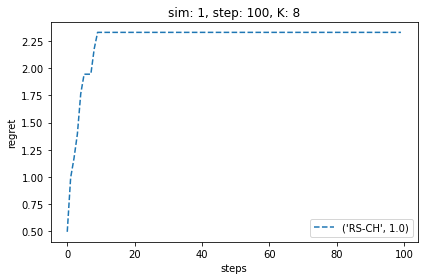

elapsed_time:0.8467497825622559[sec]


In [98]:
def main():
    trial = 1
    step = 100
    K = 8
    sim = Simulator(trial, step, K)
    sim.run()



start = time.time()
main()
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")